In [1]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import math
import datetime
import pandas as pd
import gsn_datacollector
import gsn_db
from googleads import adwords

# In[2]:

sizepop, vardim, MAXGEN, params = 1000, 7, 15, [0.9, 0.5, 0.5]
# sizepop, vardim, MAXGEN, params = 1000, 3, 10, [0.9, 0.5, 0.5]
ASSESSMENT_PERIOD = 14
BIDDING_INDEX = {
    'cpc': 'cpc_bid',
    'cpa': 'cpa_bid',
    'Target CPA': 'cpa_bid',    
}
TARGET_INDEX = {
    'cpc': 'clicks',
    'cpa': 'conversions',
    'Target CPA': 'cpa_bid',
}
CRITERIA_LIST = ['KEYWORDS']

SCORE_COLUMN_INDEX = {
    'ADGROUP': ['campaign_id', 'adgroup_id', 'score'],
    'URL': ['campaign_id', 'url_display_name', 'score'],
    'CRITERIA': ['campaign_id', 'keyword_placement', 'keyword_id', 'score'],
    'AUDIENCE': ['campaign_id', 'audience', 'criterion_id', 'score'],
    'AGE_RANGE': ['campaign_id', 'age_range', 'criterion_id', 'score'],
    'DISPLAY_KEYWORD': ['campaign_id', 'keyword', 'keyword_id', 'score'],
    'KEYWORDS': ['campaign_id', 'keyword', 'keyword_id', 'score'],
}


# In[ ]:


AUTH_FILE_PATH = '/home/tim_su/ai_optimizer/opt/ai_optimizer/googleads.yaml'
adwords_client = adwords.AdWordsClient.LoadFromStorage(AUTH_FILE_PATH)

def retrive_all_criteria_insights(campaign_id=None):
    if campaign_id:
        df = gsn_db.get_campaign(campaign_id)
        customer_id = df['customer_id'].iloc[0]
        destination_type = df['destination_type'].iloc[0]
        adwords_client.SetClientCustomerId(customer_id)
        camp = gsn_datacollector.Campaign(customer_id, campaign_id)
        for criteria in CRITERIA_LIST:
            camp.get_performance_insights( performance_type=criteria, date_preset='LAST_14_DAYS' )
        return
    df_camp = gsn_db.get_campaign()
    campaign_id_list = df_camp['campaign_id'].unique()
    # retrive all criteria insights
    for campaign_id in campaign_id_list:
        print('[campaign_id]: ', campaign_id)
        customer_id = df_camp['customer_id'][df_camp.campaign_id==campaign_id].iloc[0]
        destination_type = df_camp['destination_type'][df_camp.campaign_id==campaign_id].iloc[0]
        adwords_client.SetClientCustomerId(customer_id)
        camp = gsn_datacollector.Campaign(customer_id, campaign_id)
        for criteria in CRITERIA_LIST:
            camp.get_performance_insights( performance_type=criteria, date_preset='LAST_14_DAYS' )


# In[ ]:


def get_criteria_score( campaign_id=None, criteria=None, insights_dict=None):
    mydb = gsn_db.connectDB("dev_gsn")
    df = pd.DataFrame({'adgroup_id': [], 'target': [], 'impressions': [], 'bid_amount': []})
    # Get criteria insights from db
    table = criteria.lower()+'_insights'
    df = pd.read_sql(
        "SELECT * FROM {} WHERE campaign_id='{}' AND DATE(request_time)='{}'".format(table, campaign_id, datetime.datetime.today().date()), con=mydb)
    # Get optimal_weight from db
    df_weight = pd.read_sql(
        "SELECT * FROM optimal_weight WHERE campaign_id='{}' ".format(campaign_id), con=mydb)

    if not df.empty:
        if criteria != "URL" and criteria != "CRITERIA":
            df['daily_budget'] = insights_dict['daily_budget']
            df['bid_amount'] = df[ BIDDING_INDEX[ df['bidding_type'].iloc[0] ] ]
            df['target'] = df[ TARGET_INDEX[ df['bidding_type'].iloc[0] ] ]
            daily_destination = (insights_dict['destination']/insights_dict['period'])
            df['daily_destination'] = daily_destination
            df['conv_rate'] = (insights_dict['all_conversions']+insights_dict['conversions'])/insights_dict['clicks']
            df['first_page_cpc'] = (df['bid_amount']-df['first_page_cpc'])/df['bid_amount']
            if insights_dict['destination_type']=='LINK_CLICKS':
                df['cost_per_target'] = insights_dict['cost_per_click']
                df['all_conversions'] = 1 if insights_dict['all_conversions']>0 else 0
                df['conversions'] = 1 if insights_dict['conversions']>0 else 0
            elif insights_dict['destination_type']=='CONVERSIONS':
                df['cost_per_target'] = insights_dict['cost_per_conversion']
                df['all_conversions'] = 1 if insights_dict['all_conversions']>0 else -100
                df['conversions'] = 1 if insights_dict['conversions']>0 else -100
                
            for index, row in df.iterrows():
                df = pd.DataFrame(data=[row], columns=df.columns, index=[0])
                r = ObjectiveFunc.adgroup_fitness(df_weight, df)
                df['score'] = r
                df_final = df[ SCORE_COLUMN_INDEX[criteria] ]
                gsn_db.into_table(df_final, table=criteria.lower()+"_score")   
    mydb.close()
    return 


# In[ ]:



class GeneticAlgorithm(object):
    '''
    The class for genetic algorithm
    '''

    def __init__(self, sizepop, vardim, bound, MAXGEN, params):
        '''
        sizepop: population sizepop 種群數量
        vardim: dimension of variables 變量維度
        bound: boundaries of variables 變量邊界 -10 10 (最佳化權重上下限)
        MAXGEN: termination condition  迭代次數  1000 (子代代數)
        param: 交叉率, 變異率, alpha = [0.9, 0.1, 0.5]
        '''
        self.sizepop = sizepop
        self.MAXGEN = MAXGEN
        self.vardim = vardim
        self.bound = bound
        self.population = []
        self.fitness = np.zeros((self.sizepop, 1))
        self.trace = np.zeros((self.MAXGEN, 2))
        self.params = params

    def initialize(self):
        '''
        initialize the population
        '''
        for i in range(0, self.sizepop):
            ind = GAIndividual(self.vardim, self.bound)
            ind.generate()
            self.population.append(ind)

    def evaluate(self):
        '''
        evaluation of the population fitnesses
        '''
        for i in range(0, self.sizepop):
            self.population[i].calculate_fitness()
            self.fitness[i] = self.population[i].fitness

    def solve(self):
        '''
        evolution process of genetic algorithm
        '''
        self.t = 0
        self.initialize()
        self.evaluate()
        best = np.max(self.fitness)
        bestIndex = np.argmax(self.fitness)
        self.best = copy.deepcopy(self.population[bestIndex])
        self.avefitness = np.mean(self.fitness)
#         self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
#         self.trace[self.t, 1] = (1 - self.avefitness) / self.avefitness
        self.trace[self.t, 0] = self.best.fitness
        self.trace[self.t, 1] = self.avefitness
        print("Generation %d: optimal function value is: %f; average function value is %f" % (
            self.t, self.trace[self.t, 0], self.trace[self.t, 1]))
        while (self.t < self.MAXGEN - 1):
            self.t += 1
            self.selection_operation()
            self.crossover_operation()
            self.mutation_operation()
            self.evaluate()
            best = np.max(self.fitness)
            bestIndex = np.argmax(self.fitness)
            if best > self.best.fitness:
                self.best = copy.deepcopy(self.population[bestIndex])
            self.avefitness = np.mean(self.fitness)
#             self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
#             self.trace[self.t, 1] = (1 - self.avefitness) / self.avefitness
            self.trace[self.t, 0] = self.best.fitness
            self.trace[self.t, 1] = self.avefitness
            print("Generation %d: optimal function value is: %f; average function value is %f" % (
                self.t, self.trace[self.t, 0], self.trace[self.t, 1]))

        print("Optimal function value is: %f; " %
              self.trace[self.t, 0])
        print("Optimal solution is:")
        print(self.best.chrom)
        self.print_result()
        return self.best.chrom

    def selection_operation(self):
        '''
        selection operation for Genetic Algorithm
        '''
        newpop = []
        totalFitness = np.sum(self.fitness)
        accuFitness = np.zeros((self.sizepop, 1))

        sum1 = 0.
        for i in range(0, self.sizepop):
            accuFitness[i] = sum1 + self.fitness[i] / totalFitness
            sum1 = accuFitness[i]

        for i in range(0, self.sizepop):
            r = random.random()
            idx = 0
            for j in range(0, self.sizepop - 1):
                if j == 0 and r < accuFitness[j]:
                    idx = 0
                    break
                elif r >= accuFitness[j] and r < accuFitness[j + 1]:
                    idx = j + 1
                    break
            newpop.append(self.population[idx])
        self.population = newpop

    def crossover_operation(self):
        '''
        crossover operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop, 2):
            idx1 = random.randint(0, self.sizepop - 1)
            idx2 = random.randint(0, self.sizepop - 1)
            while idx2 == idx1:
                idx2 = random.randint(0, self.sizepop - 1)
            newpop.append(copy.deepcopy(self.population[idx1]))
            newpop.append(copy.deepcopy(self.population[idx2]))
            r = random.random()
            if r < self.params[0]:
                crossPos = random.randint(1, self.vardim - 1)
                for j in range(crossPos, self.vardim):
                    newpop[i].chrom[j] = newpop[i].chrom[
                        j] * self.params[2] + (1 - self.params[2]) * newpop[i + 1].chrom[j]
                    newpop[i + 1].chrom[j] = newpop[i + 1].chrom[j] * self.params[2] +                         (1 - self.params[2]) * newpop[i].chrom[j]
        self.population = newpop

    def mutation_operation(self):
        '''
        mutation operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop):
            newpop.append(copy.deepcopy(self.population[i]))
            r = random.random()
            if r < self.params[1]:
                mutatePos = random.randint(0, self.vardim - 1)
                theta = random.random()
                if theta > 0.5:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] - (newpop[i].chrom[mutatePos] - self.bound[0, mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
                else:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] + (self.bound[1, mutatePos] - newpop[i].chrom[mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
        self.population = newpop

    def print_result(self):
        '''
        plot the result of the genetic algorithm
        '''
        x = np.arange(0, self.MAXGEN)
        y1 = self.trace[:, 0]
        y2 = self.trace[:, 1]
        plt.plot(x, y1, 'r', label='optimal value')
        plt.plot(x, y2, 'g', label='average value')
        plt.xlabel("Iteration")
        plt.ylabel("function value")
        plt.title("Genetic algorithm for function optimization")
        plt.legend()
        plt.show()


class GAIndividual(object):
    '''
    individual of genetic algorithm
    '''

    def __init__(self,  vardim, bound):
        '''
        vardim: dimension of variables
        bound: boundaries of variables
        '''
        self.vardim = vardim
        self.bound = bound
        self.fitness = 0.

    def generate(self):
        '''
        generate a random chromsome for genetic algorithm
        '''
        len = self.vardim
        rnd = np.random.random(size=len)
        self.chrom = np.zeros(len)
        for i in range(0, len):
            self.chrom[i] = self.bound[0, i] +                 (self.bound[1, i] - self.bound[0, i]) * rnd[i]

    def calculate_fitness(self):
        '''
        calculate the fitness of the chromsome
        '''
        self.fitness = ObjectiveFunc.fitnessfunc(self.chrom, df)


class ObjectiveFunc(object):
    '''
    objective function of genetic algorithm
    '''

    def __init__(self):
        self.DATABASE = 'dev_gsn'
        self.mydb = gsn_db.connectDB(self.DATABASE)
        self.AUTH_FILE_PATH = '/home/tim_su/ai_optimizer/opt/ai_optimizer/googleads.yaml'
        self.client = adwords.AdWordsClient.LoadFromStorage(
            self.AUTH_FILE_PATH)

    def fitnessfunc(optimal_weight, df):
        
        m_kpi = ( df['campaign_click'] / df['daily_destination'] ).apply(np.tanh)
        m_spend = ( (df['spend_cap'] - df['spend']) / df['spend_cap'] ).apply(np.exp)
        m_bid = ( (df['campaign_bid'] - df['campaign_cpc']) / df['campaign_bid'] ).apply(np.exp)
        
        # We consider all_conv for converiosn campaign
        #[conv, all_conv, (conv+all_conv)/clicks, m_kpi, m_spend, m_bid]
        m_all_conv = df['campaign_all_conv']
        m_conv = df['campaign_conversion']
        m_conv_rate = df['campaign_conv_rate']
        m_ave_position = pd.Series([-1], index=[0]) if df['average_position'].iloc[0]>2 or df['average_position'].iloc[0]<=1 else 1/(df['average_position']-0.9) 

        m_bid = m_bid if df['campaign_cpc'].iloc[0]!=0 else pd.Series([-1], index=[0])
        
        status = np.array([m_ave_position, m_conv, m_all_conv, m_conv_rate, m_kpi, m_spend, m_bid])
        r = np.dot(optimal_weight, status)
        return r

    def adgroup_fitness(optimal_weight, df):
        m_kpi = ( df['target'] / df['daily_destination'] ).apply(np.tanh) * 10
        m_kpi = pd.Series([-100], index=[0]) if df['target'].iloc[0] == 0 else m_kpi
        
        m_spend = ( (df['daily_budget'] - df['spend']) / df['daily_budget'] ).apply(np.exp)
        m_bid = ((df['bid_amount'] - df['cost_per_target']) / df['bid_amount']).astype(float).apply(np.exp)
        
        m_all_conv = df['all_conversions']
        m_conv = df['conversions']
        m_conv_rate = (df['all_conversions']+df['conversions'])/df['clicks']
        m_ave_position = pd.Series([-1], index=[0]) if df['position'].iloc[0]>2 or df['position'].iloc[0]<=1 else 1/(df['position']-0.9)
        m_first_page = pd.Series([1], index=[0]) if df['first_page_cpc'].iloc[0]>0 else pd.Series([0], index=[0])
        with np.errstate(divide='ignore', invalid='ignore'):
            m_conv_rate = np.true_divide( (df['conversions']+df['all_conversions']), df['clicks'] )
            m_conv_rate[m_conv_rate == np.inf] = 0
            m_conv_rate[m_conv_rate == -np.inf] = 0
            m_conv_rate = np.nan_to_num(m_conv_rate)
        
        status = np.array([m_ave_position, m_conv, m_all_conv, m_conv_rate, m_kpi, m_spend, m_bid, m_first_page])
        optimal_weight = np.array([
            optimal_weight['weight_ave_position'].iloc[0],
            optimal_weight['weight_conv'].iloc[0],
            optimal_weight['weight_all_conv'].iloc[0],
            optimal_weight['weight_conv_rate'].iloc[0],
            optimal_weight['weight_kpi'].iloc[0],
            optimal_weight['weight_spend'].iloc[0],
            optimal_weight['weight_bid'].iloc[0],
            optimal_weight['weight_first_page'].iloc[0]
        ])
        r = np.dot(optimal_weight, status)
#         print(optimal_weight)
        return r

    def campaign_status(self, campaign_id, insights_dict):
        destination_type = insights_dict['destination_type']
        spend = insights_dict['spend']
        daily_budget = insights_dict['daily_budget']
        campaign_click = insights_dict['clicks']
        impressions = insights_dict['impressions']
        spend_cap = insights_dict['daily_budget'] * ASSESSMENT_PERIOD
        daily_destination = (insights_dict['destination']/insights_dict['period'])
        campaign_bid = daily_budget/daily_destination
        campaign_conv_rate = (insights_dict['all_conversions']+insights_dict['conversions'])/insights_dict['clicks']
        
        average_position = insights_dict['average_position']
        
        if destination_type=='LINK_CLICKS':
            campaign_cpt = insights_dict['cost_per_click']
            campaign_all_conv = 1 if insights_dict['all_conversions'] > 0 else 0
            campaign_conversion = 1 if insights_dict['conversions']>0 else 0
        elif destination_type=='CONVERSIONS':
            campaign_cpt = insights_dict['cost_per_conversion']
            campaign_all_conv = 1 if insights_dict['all_conversions']>0 else -1
            campaign_conversion = 1 if insights_dict['conversions']>0 else -2

        campaign_status_dict = {
            'campaign_id': [campaign_id],
            'campaign_cpc': [campaign_cpt],
            'campaign_conversion': [campaign_conversion],
            'campaign_click': [campaign_click],
            'campaign_all_conv': [campaign_all_conv],
            'campaign_conversion': [campaign_conversion],
            'campaign_conv_rate': [campaign_conv_rate],
            'average_position': [average_position],
            'impressions': [impressions],
            'campaign_bid': [campaign_bid],
            'spend': [spend],
            'daily_budget': [daily_budget],
            'daily_destination': [daily_destination],
            'spend_cap': [spend_cap]
        }
        df = pd.DataFrame(campaign_status_dict)
        df = df.convert_objects(convert_numeric=True)
        self.mydb.close()
        return df

    def adgroup_status(self, adgroup_id):
        return


[campaign_id]:  1073506211
[campaign_id]:  1073506208
[campaign_id list]:  [1073506211, 1073506208]
[current time]:  2019-06-14 16:50:42.070047
[campaign_id]: 1073506211


/home/tim_su/.local/lib/python3.6/site-packages/ipykernel_launcher.py:412: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


Generation 0: optimal function value is: 5.811254; average function value is 3.357014
Generation 1: optimal function value is: 5.811254; average function value is 3.555212
Generation 2: optimal function value is: 5.961273; average function value is 3.782588
Generation 3: optimal function value is: 5.961273; average function value is 3.909442
Generation 4: optimal function value is: 5.961273; average function value is 4.020369
Generation 5: optimal function value is: 5.961273; average function value is 4.092127
Generation 6: optimal function value is: 5.961273; average function value is 4.183269
Generation 7: optimal function value is: 5.961273; average function value is 4.240800
Generation 8: optimal function value is: 5.961273; average function value is 4.347218
Generation 9: optimal function value is: 5.961273; average function value is 4.382460
Generation 10: optimal function value is: 5.961273; average function value is 4.416604
Generation 11: optimal function value is: 5.961273; a

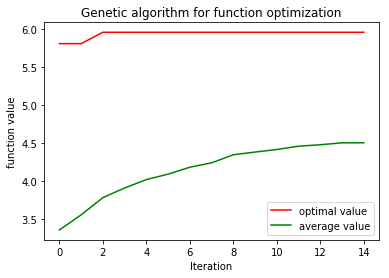

   weight_ave_position  weight_conv  weight_all_conv  weight_conv_rate  \
0              0.93553     0.933896         0.987558          0.965909   

   weight_kpi  weight_spend  weight_bid  weight_first_page  campaign_id  \
0    0.618416      0.927014     0.38948                0.9   1073506211   

      score  
0  5.961273  
optimal_weight: [0.93553005 0.93389637 0.98755835 0.96590935 0.61841617 0.92701408
 0.38947994]
0:01:03.800527
[current time]:  2019-06-14 16:51:40.013973
[campaign_id]: 1073506208


/home/tim_su/.local/lib/python3.6/site-packages/ipykernel_launcher.py:412: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


Generation 0: optimal function value is: 6.149318; average function value is 3.542410
Generation 1: optimal function value is: 6.257821; average function value is 3.957268
Generation 2: optimal function value is: 6.257821; average function value is 4.144169
Generation 3: optimal function value is: 6.291892; average function value is 4.273798
Generation 4: optimal function value is: 6.314410; average function value is 4.450334
Generation 5: optimal function value is: 6.314410; average function value is 4.518263
Generation 6: optimal function value is: 6.379777; average function value is 4.620092
Generation 7: optimal function value is: 6.425784; average function value is 4.702284
Generation 8: optimal function value is: 6.425784; average function value is 4.848471
Generation 9: optimal function value is: 6.425784; average function value is 4.946359
Generation 10: optimal function value is: 6.425784; average function value is 4.963585
Generation 11: optimal function value is: 6.425784; a

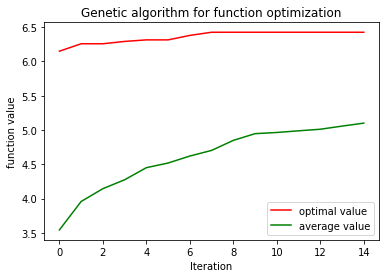

   weight_ave_position  weight_conv  weight_all_conv  weight_conv_rate  \
0             0.976985     0.858169         0.902537          0.549581   

   weight_kpi  weight_spend  weight_bid  weight_first_page  campaign_id  \
0    0.961207      0.668764    0.468262                0.9   1073506208   

      score  
0  6.425784  
optimal_weight: [0.97698543 0.85816908 0.90253749 0.54958053 0.96120662 0.66876442
 0.468262  ]
0:02:02.637338
0:02:02.637375


In [2]:
if __name__ == "__main__":
    starttime = datetime.datetime.now()
    retrive_all_criteria_insights()
    df_camp = gsn_db.get_campaign()
    campaign_id_list = df_camp['campaign_id'].tolist()
    print('[campaign_id list]: ', campaign_id_list)
    for campaign_id in campaign_id_list:
        print('[current time]: ', datetime.datetime.now())
        print('[campaign_id]:', campaign_id )
        customer_id = df_camp['customer_id'][df_camp.campaign_id==campaign_id].iloc[0]
        destination_type = df_camp['destination_type'][df_camp.campaign_id==campaign_id].iloc[0]
        camp = gsn_datacollector.Campaign(customer_id, campaign_id)
        df_insights = camp.get_performance_insights(date_preset='YESTERDAY', performance_type='CAMPAIGN')
        insights_dict = df_insights.to_dict(orient='records')[0]
        insights_dict['period'] = df_camp['period'][df_camp.campaign_id==campaign_id].iloc[0]
        insights_dict['destination'] = df_camp['destination'][df_camp.campaign_id==campaign_id].iloc[0]
        insights_dict['destination_type'] = destination_type
        global df
        df = ObjectiveFunc().campaign_status( campaign_id, insights_dict )

        bound = np.tile([[0], [1]], vardim)
        ga = GeneticAlgorithm(sizepop, vardim, bound, MAXGEN, params)
        optimal = ga.solve()
        score = ObjectiveFunc.fitnessfunc(optimal, df)

        weight_first_page = 0.9 if destination_type == 'CONVERSIONS' else 0
        
        score_columns=['weight_ave_position', 'weight_conv','weight_all_conv','weight_conv_rate','weight_kpi', 'weight_spend', 'weight_bid', 'weight_first_page']

        df_score = pd.DataFrame(data=[np.append(optimal, [weight_first_page])], columns=score_columns, index=[0])

        df_final = pd.DataFrame({'campaign_id':campaign_id, 'score':score}, index=[0])

        df_final = pd.concat( [df_score, df_final], axis=1, sort=True, ignore_index=False)
        
        print(df_final)
        gsn_db.check_optimal_weight(campaign_id, df_final)
        for criteria in CRITERIA_LIST:
            get_criteria_score( campaign_id=campaign_id, criteria=criteria, insights_dict=insights_dict )
            break
        print('optimal_weight:', optimal)
        print(datetime.datetime.now()-starttime)
    print(datetime.datetime.now()-starttime)
    import gc
    gc.collect()


In [3]:
#!jupyter nbconvert --to script genetic_algorithm_gsn.ipynb

In [4]:
np.append(optimal, [0.9])

array([0.97698543, 0.85816908, 0.90253749, 0.54958053, 0.96120662,
       0.66876442, 0.468262  , 0.9       ])